# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">CASE ITAU</p>

## O Case

Este case consiste em um exercício prático de construção de um modelo e quais insights você consegue extrair dos dados.

Desenhamos o case para que você possa mostrar as suas habilidades como cientista de dados.

O conjunto de dados que fornecemos contém observações diárias do clima de algumas estações meteorológicas na Austrália.
 
Os dados estão organizados em duas tabelas:

- `rain_data_aus.csv`: Contém a maior parte das informações, já centralizadas, de todas as estações.

- `wind_table_01.csv a wind_table_08.csv`: Contém informações sobre velocidade e orientação de ventos.

As tabelas estão apartadas, pois são originadas de um outro instrumento e salvas em um sistema apartado.

Submeta os arquivos em um repositório no git e nos envie o link para avaliação.

Idealmente, queremos poder replicar sua análise a partir dos códigos enviados. Portanto, especifique as versões das ferramentas e pacotes que você está usando.

## Objetivo:

Construir um modelo preditivo para determinar se vai ou não chover amanhã.

---

<a id="3"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Config</p>

In [6]:
import platform

print('Version      :', platform.python_version())
print('Compiler     :', platform.python_compiler())
print('Normal       :', platform.platform())

Version      : 3.9.13
Compiler     : MSC v.1916 64 bit (AMD64)
Normal       : Windows-10-10.0.19044-SP0


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve
import warnings
import seaborn as sns
warnings.simplefilter("ignore")

In [28]:
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Seaborn version: {sns.__version__}')

Pandas version: 1.4.4
Numpy version: 1.21.5
Seaborn version: 0.11.2


In [8]:
# Display Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<a id="3"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data Inspection: Rain data</p>

**Importing the dataset**

In [10]:
rain = pd.read_csv('data/rain_data_aus.csv')

In [11]:
rain.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,40.76,41.600000,9,11.883546,0.220164


In [31]:
rain[['amountOfRain','rainfall','raintoday','raintomorrow']].head(20)

# ok, raintoday é "sim" ou "não", baseado no rainfall. SIM se rainfall > 1.0, NÃO se menor que 1.0
# amountOfRain é a rainfall lagada por -1 dia. Por enquanto vou dropar essa coluna para evitar vazamento de dados. Idem para modelo vigente.

,amountOfRain,rainfall,raintoday,raintomorrow
0,0.0,0.6,No,No
1,0.0,0.0,No,No
2,0.0,0.0,No,No
3,1.0,0.0,No,No
4,0.2,1.0,No,No
5,0.0,0.2,No,No
6,0.0,0.0,No,No
7,0.0,0.0,No,No
8,1.4,0.0,No,Yes
9,0.0,1.4,Yes,No


In [13]:
rain_new = rain.drop(columns=['amountOfRain','modelo_vigente'])

In [14]:
rain.shape

(142193, 23)

In [15]:
rain_new.shape

(142193, 21)

In [17]:
rain_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              142193 non-null  object 
 1   location          142193 non-null  object 
 2   mintemp           141556 non-null  float64
 3   maxtemp           141871 non-null  float64
 4   rainfall          140787 non-null  float64
 5   evaporation       81350 non-null   float64
 6   sunshine          74377 non-null   float64
 7   humidity9am       140419 non-null  float64
 8   humidity3pm       138583 non-null  float64
 9   pressure9am       128179 non-null  float64
 10  pressure3pm       128212 non-null  float64
 11  cloud9am          88536 non-null   float64
 12  cloud3pm          85099 non-null   float64
 13  temp9am           141289 non-null  float64
 14  temp3pm           139467 non-null  float64
 15  raintoday         140787 non-null  object 
 16  raintomorrow      14

In [25]:
rain_new[rain_new.duplicated()]

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am


**Insights:**

- Date is object. Convert to datetime.
- Several NaNs in several columns. Investigate.
- No duplicates here

<AxesSubplot:>

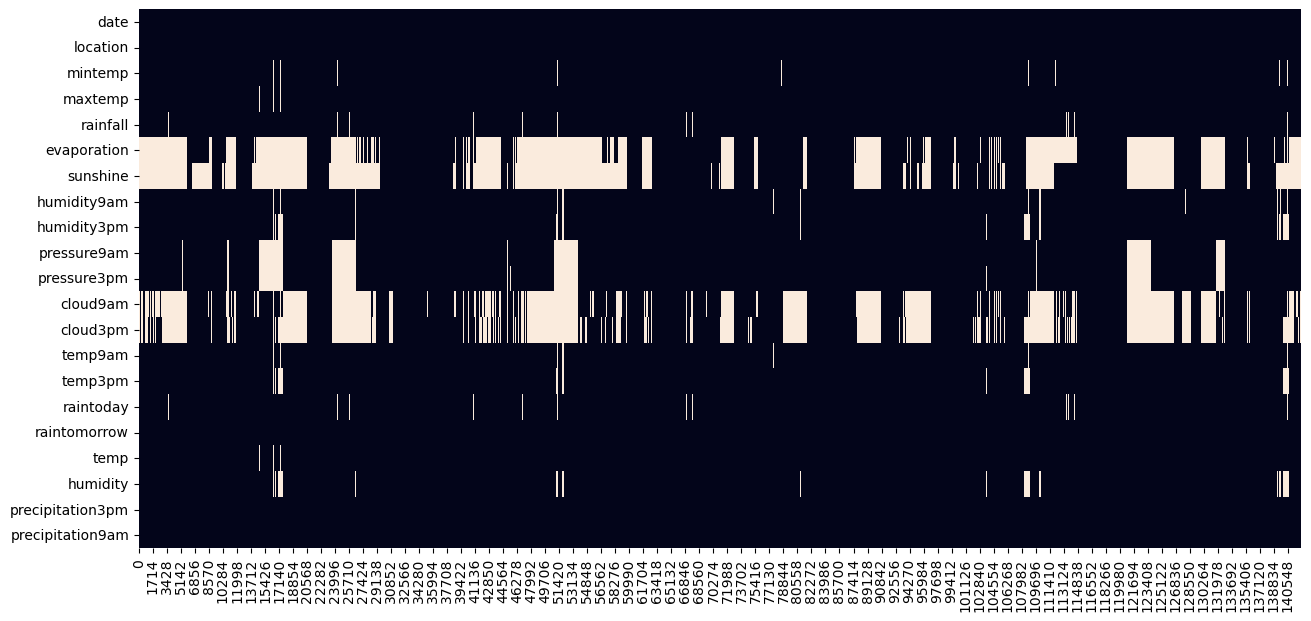

In [32]:
fig, ax = plt.subplots(figsize=(15,7))

# wind_nan = wind.loc[wind.isna()]
sns.heatmap(rain_new.isnull().T, cbar=False, ax=ax) # Cada ponto branco corresponde a um dado vazio

In [36]:
# Converting date
rain_new['date'] = pd.to_datetime(rain_new['date'])

In [37]:
rain_new.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,29.48,28.400000,12,5.115360
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,32.12,2.208569,10,21.497100
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,32.84,38.000000,17,20.782859
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,35.60,21.200000,8,12.028646
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,40.76,41.600000,9,11.883546


In [ ]:
# Variable | Description
# ---------|------------
# Date   |  The date of observation
# Location   |  The common name of the location of the weather station
# MinTemp   |  The minimum temperature in degrees celsius
# MaxTemp   |  The maximum temperature in degrees celsius
# Rainfall   |  The amount of rainfall recorded for the day in mm
# Evaporation   |  The so-called Class A pan evaporation (mm) in the 24 hours to 9am
# Sunshine   |  The number of hours of bright sunshine in the day.
# WindGustDir   |  The direction of the strongest wind gust in the 24 hours to midnight
# WindGustSpeed   |  The speed (km/h) of the strongest wind gust in the 24 hours to midnight
# WindDir9am   |  Direction of the wind at 9am
# WindDir3pm   |  Direction of the wind at 3pm
# WindSpeed9am   |  Wind speed (km/hr) averaged over 10 minutes prior to 9am
# WindSpeed3pm   |  Wind speed (km/hr) averaged over 10 minutes prior to 3pm
# Humidity9am   |  Humidity (percent) at 9am
# Humidity3pm   |  Humidity (percent) at 3pm
# Pressure9am   |  Atmospheric pressure (hpa) reduced to mean sea level at 9am
# Pressure3pm   |  Atmospheric pressure (hpa) reduced to mean sea level at 3pm
# Cloud9am   |  Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
# Cloud3pm | Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
# Temp9am |  Temperature (degrees C) at 9am
# Temp3pm |  Temperature (degrees C) at 3pm
# Precipitation9am |  The amount of rain in mm prior to 9am
# Precipitation3pm |  The amount of rain in mm prior to 3pm
# AmountOfRain |  The amount of rain in mm
# Temp |  Temperature (degrees C)
# Humidity |  Humidity (percent)
# RainToday |  Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
# RainTomorrow |  The target variable. Did it rain tomorrow?

In [18]:
rain_new.describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,temp,humidity,precipitation3pm,precipitation9am
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,141871.000000,138583.000000,142193.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,28.505419,61.991179,10.014164,10.000748
std,6.403283,7.117618,8.465173,4.188537,3.781525,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,10.237506,26.649111,3.169832,4.997908
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,-3.760000,2.000000,0.000000,-17.739346
25%,7.600000,17.900000,0.000000,2.600000,4.900000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,22.520000,44.000000,8.000000,6.650238
50%,12.000000,22.600000,0.000000,4.800000,8.500000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,28.520000,63.200000,10.000000,10.000009
75%,16.800000,28.200000,0.800000,7.400000,10.600000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,35.480000,80.000000,12.000000,13.389306
max,33.900000,48.100000,371.000000,145.000000,14.500000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,59.720000,122.000000,26.000000,32.478590


In [25]:
rain['location'].unique().size # There are 49 locations

49

In [40]:
rain['date'].unique() # 3436 distinct dates, '2007-11-01' to '2017-06-25', about 9 years and a half of data (from size)

array(['2008-12-01', '2008-12-02', '2008-12-03', ..., '2008-01-29',
       '2008-01-30', '2008-01-31'], dtype=object)

Modifying the dataset e.g. Yes and No to 1s and 0s respectively

In [38]:
rain_new.loc[rain_new['raintoday'] == 'No','raintoday'] = 0
rain_new.loc[rain_new['raintoday'] == 'Yes','raintoday'] = 1

rain_new.loc[rain_new['raintomorrow'] == 'No','raintomorrow'] = 0
rain_new.loc[rain_new['raintomorrow'] == 'Yes','raintomorrow'] = 1

In [30]:
# Done. Now I will create a dataset with ALL nans removed. This will drastically remove the size of rows, but it's good for a first approach
rain_excised = rain_new.dropna() # drop indiscriminately

In [32]:
rain_new.shape

(142193, 21)

In [31]:
rain_excised.shape #down from 142k lines to 62k lines

(61918, 21)

In [33]:
rain_excised.head()
# There isn't an uniform pattern of dates anymore. Some locations are gone (maybe those without evaporation or sunshine stations).

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am
5939,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,44.24,17.6,5,15.165784
5940,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,36.68,11.6,9,9.750834
5942,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,47.12,28.4,11,5.557986
5943,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,48.08,28.4,10,17.820001
5944,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,51.20,20.0,9,13.217116


In [36]:
rain_excised.info()
#oh oh 15 and 16 are still objects. Lets change them to int:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61918 entries, 5939 to 139112
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              61918 non-null  object 
 1   location          61918 non-null  object 
 2   mintemp           61918 non-null  float64
 3   maxtemp           61918 non-null  float64
 4   rainfall          61918 non-null  float64
 5   evaporation       61918 non-null  float64
 6   sunshine          61918 non-null  float64
 7   humidity9am       61918 non-null  float64
 8   humidity3pm       61918 non-null  float64
 9   pressure9am       61918 non-null  float64
 10  pressure3pm       61918 non-null  float64
 11  cloud9am          61918 non-null  float64
 12  cloud3pm          61918 non-null  float64
 13  temp9am           61918 non-null  float64
 14  temp3pm           61918 non-null  float64
 15  raintoday         61918 non-null  object 
 16  raintomorrow      61918 non-null  ob

In [39]:
rain_excised['raintoday'] = rain_excised.raintoday.astype(int)
rain_excised['raintomorrow'] = rain_excised.raintomorrow.astype(int)

First dataset is ready. 

In [41]:
rain_excised.corr()
# great, 15 and 16 are part of the corr matrix now.
# Do I want to think about correlations with date and/or locations?

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am
mintemp,1.000000,0.743674,0.110846,0.510004,0.070680,-0.177758,0.076333,-0.475451,-0.491435,0.115204,0.050917,0.905552,0.720796,0.051478,0.088964,0.578773,0.068579,0.003508,-0.001382
maxtemp,0.743674,1.000000,-0.069482,0.652247,0.461698,-0.496329,-0.448043,-0.355855,-0.454047,-0.262003,-0.253183,0.890743,0.984101,-0.220012,-0.144498,0.779778,-0.406402,0.003385,-0.001055
rainfall,0.110846,-0.069482,1.000000,-0.074049,-0.243738,0.258127,0.270421,-0.177673,-0.133452,0.215699,0.191743,0.014438,-0.073640,0.553481,0.253773,-0.060093,0.247128,-0.007556,-0.003066
evaporation,0.510004,0.652247,-0.074049,1.000000,0.366577,-0.554104,-0.414895,-0.304406,-0.330799,-0.192775,-0.196180,0.598609,0.631686,-0.213291,-0.127257,0.509947,-0.375537,0.007043,-0.000189
sunshine,0.070680,0.461698,-0.243738,0.366577,1.000000,-0.498855,-0.622767,0.035783,-0.027949,-0.678801,-0.704871,0.285678,0.483256,-0.327720,-0.449261,0.359295,-0.565134,-0.003376,0.004404
humidity9am,-0.177758,-0.496329,0.258127,-0.554104,-0.498855,1.000000,0.679847,0.122421,0.178441,0.432826,0.344565,-0.426737,-0.487789,0.371288,0.265360,-0.388460,0.617538,-0.003913,-0.001670
humidity3pm,0.076333,-0.448043,0.270421,-0.414895,-0.622767,0.679847,1.000000,-0.057837,0.028653,0.507677,0.507461,-0.148491,-0.498921,0.376480,0.447742,-0.351533,0.907959,-0.003120,-0.003777
pressure9am,-0.475451,-0.355855,-0.177673,-0.304406,0.035783,0.122421,-0.057837,1.000000,0.961926,-0.142788,-0.164998,-0.447688,-0.314549,-0.183468,-0.255934,-0.274905,-0.052670,-0.002484,0.003967
pressure3pm,-0.491435,-0.454047,-0.133452,-0.330799,-0.027949,0.178441,0.028653,0.961926,1.000000,-0.074193,-0.101631,-0.500713,-0.422233,-0.100839,-0.231428,-0.351972,0.025834,-0.002560,0.004046
cloud9am,0.115204,-0.262003,0.215699,-0.192775,-0.678801,0.432826,0.507677,-0.142788,-0.074193,1.000000,0.612633,-0.101916,-0.278856,0.297414,0.319410,-0.203947,0.460164,-0.000451,-0.000973


Is unsupervised machine learning useful here? e.g. clusterization?

Separação das variáveis X e y

X = rain_data_aus.drop(columns=['raintomorrow'])
y = pd.Series(rain_data_aus['raintomorrow'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y?)

<a id="3"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data Inspection: Wind data 1-8</p>

In [19]:

wind = pd.concat([pd.read_csv(f'data/wind_table_0{i}.csv',sep=',') for i in range(1,8)])

In [20]:
wind.head()

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 22192
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            142193 non-null  object 
 1   location        142193 non-null  object 
 2   wind_gustdir    36419 non-null   object 
 3   wind_gustspeed  36426 non-null   float64
 4   wind_dir9am     36932 non-null   object 
 5   wind_dir3pm     38990 non-null   object 
 6   wind_speed9am   39300 non-null   float64
 7   wind_speed3pm   39328 non-null   float64
 8   windgustdir     96444 non-null   object 
 9   windgustspeed   96497 non-null   float64
 10  winddir9am      95248 non-null   object 
 11  winddir3pm      99425 non-null   object 
 12  windspeed9am    101545 non-null  float64
 13  windspeed3pm    100235 non-null  float64
dtypes: float64(6), object(8)
memory usage: 16.3+ MB


**Insights**

- date is also object here. Convert to datetime.
- several NaNs in several columns.

<AxesSubplot:>

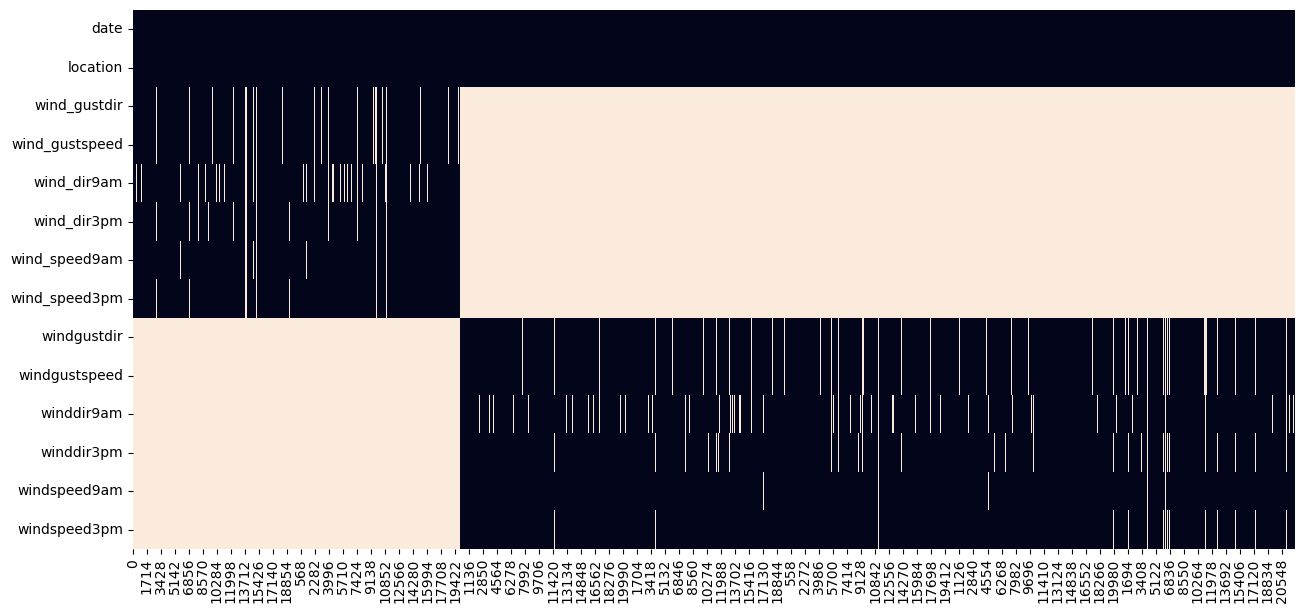

In [29]:
fig, ax = plt.subplots(figsize=(15,7))

# wind_nan = wind.loc[wind.isna()]
sns.heatmap(wind.isnull().T, cbar=False, ax=ax) # Cada ponto branco corresponde a um dado vazio

In [24]:
wind[wind.duplicated()] # No duplicates here

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm


In [39]:
# Converting date
wind['date'] = pd.to_datetime(wind['date'])

In [40]:
wind.head()

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN


<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤMerging both datasets on date and locationㅤ</span>

Both datasets have 142,193 entries, matching dates. Let's add the data (more info for the model)

In [ ]:
wind_rain =pd.merge(rain,wind,on=['date','location'],how ='left')
wind_rain.head()